<a href="https://colab.research.google.com/github/protmaks/Azure-Databricks/blob/main/Graph_of_Table_Dependencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install networkx matplotlib

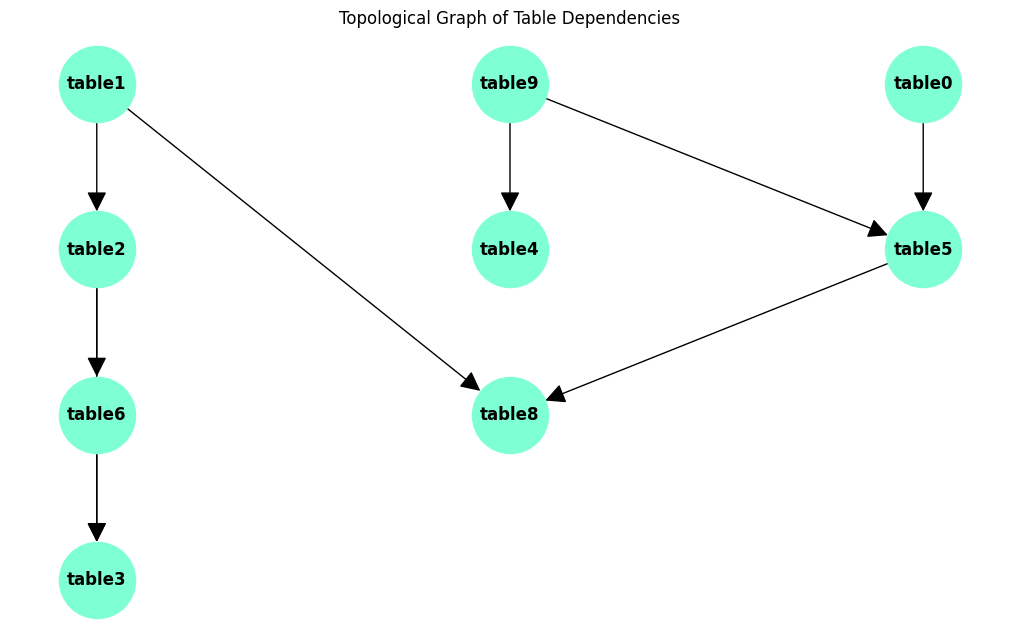

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Table dependencies in the specified format
dependencies = [
    ('table1', 'table2'),
    ('table2', 'table3'),
    ('table9', 'table4'),
    ('table2', 'table6'),
    ('table0', 'table5'),
    ('table1', 'table8'),
    ('table6', 'table3'),
    ('table5', 'table8'),
    ('table9', 'table5')
]

# Loading data into DataFrame
df = pd.DataFrame(dependencies, columns=['src', 'tgt'])

# Creating a directed graph
G = nx.DiGraph()

# Adding edges from the data
for index, row in df.iterrows():
    G.add_edge(row['src'], row['tgt'])

# Getting topological generations
generations = list(nx.topological_generations(G))

# Creating coordinates for nodes
pos = {}
y = 0
for generation in generations:
    x = 0
    for node in generation:
        pos[node] = (x, y)
        x += 1
    y -= 1

# Visualizing the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='#7FFFD4', font_size=12, font_weight='bold', arrowsize=30)
plt.title('Topological Graph of Table Dependencies')
plt.show()

# **Auto analysis of Databricks script and building of topological graph of table dependencies in Python**

In [ ]:
with open('RA0563.py', 'r') as file:
    sql_code = file.read()

In [ ]:
import re
import pprint

def parse_sql_dependencies(sql_code):
    dependencies = []
    cached_tables = []

    create_patterns = [
        r'saveAsTable\s*\(\s*f?[\'"]([^\'"]+)[\'"]\s*\)',
        r'createOrReplaceTempView\s*\(\s*f?[\'"]([^\'"]+)[\'"]\s*\)'
    ]

    usage_patterns = [
        r'FROM\s+([^\s;]+)',
        r'JOIN\s+([^\s;]+)',
        r'spark\.table\s*\(\s*f?[\'"]([^\'"]+)[\'"]\s*\)'
    ]

    cache_pattern = r'CACHE\s+TABLE\s+([^\s]+)\s+options\s*\('

    blocks = re.split(r'# COMMAND ----------|\n--', sql_code)
    for block in blocks:
        created_views = []
        used_tables = set()

        for pattern in create_patterns:
            created_views.extend(re.findall(pattern, block, re.IGNORECASE))

        for pattern in usage_patterns:
            found_tables = re.findall(pattern, block, re.IGNORECASE)
            for table in found_tables:
                if "(" in table:
                    nested_tables = re.findall(r'\bFROM\b\s+([^\s;]+)|\bJOIN\b\s+([^\s;]+)', table, re.IGNORECASE)
                    used_tables.update([t for ts in nested_tables for t in ts if t])
                else:
                    used_tables.add(table)

        union_tables = re.findall(r'unionByName\(([^,]+),', block, re.IGNORECASE)
        for union in union_tables:
            ref_tables = re.findall(r'spark\.table\s*\(\s*f?[\'"]([^\'"]+)[\'"]\s*\)', union, re.IGNORECASE)
            used_tables.update(ref_tables)

        for view in created_views:
            for used in used_tables:
                dependencies.append((used, view))

        # Поиск закэшированных таблиц
        cached = re.findall(cache_pattern, block, re.IGNORECASE)
        cached_tables.extend(cached)

    return dependencies, cached_tables

dependencies, cached_tables = parse_sql_dependencies(sql_code)

#pprint.pprint(dependencies)
dependencies = [dep for dep in dependencies if dep[0] != dep[1]]
print("Dependencies:")
pprint.pprint(dependencies)

print("\nCached Tables:")
pprint.pprint(cached_tables)

In [ ]:
import pandas as pd

df = pd.DataFrame(dependencies, columns=['Source', 'Target'])
#display(df)

grouped = df.groupby('Source').size()
result_df = grouped.reset_index(name='Count').sort_values('Count', ascending=False)
result_df['Cached Status'] = result_df['Source'].apply(lambda x: 'CACHED' if x in cached_tables else '')
#display(result_df)

filtered_df = result_df[~result_df['Source'].str.startswith('{') & (result_df['Count'] > 1) | (result_df['Cached Status'] =='CACHED')]
display(filtered_df)

,Source,Count,Cached Status
10,COM__LW_TODAY,6,CACHED
14,COM__SA_WITH_DPSOC_TODAY,5,CACHED
6,COM__IN_LW_NOTIN_SA,2,
19,COM__SOC_DESCRIPTION1,2,
12,COM__LW_TODAY2,2,
7,COM__IN_SA_NOTIN_LW,2,
0,COM__BA,2,
4,COM__IMEI_MISMATCH,2,
20,COM__SOC_MISMATCH,2,


In [ ]:
!pip install networkx matplotlib pydot
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

df = pd.DataFrame(dependencies, columns=['src', 'tgt'])

G = nx.DiGraph()

for index, row in df.iterrows():
    G.add_edge(row['src'], row['tgt'])

node_colors = []
for node in G.nodes():
    if node in cached_tables:
      node_colors.append('red')
    elif '.{' in node:
      node_colors.append('orange')
    elif '.' in node:
      node_colors.append('#A6FFA6')
    else:
      node_colors.append('skyblue')

pos = graphviz_layout(G, prog='dot')
plt.figure(figsize=(35, 30))
nx.draw(G, pos, with_labels=True, node_size=5000, node_color=node_colors, font_size=10, font_weight='bold', arrowsize=30)
plt.title('Graph of Table Dependencies')
plt.show()

NameError: name 'dependencies' is not defined

In [ ]:
import pandas as pd

df = pd.DataFrame(dependencies, columns=['Source', 'Target'])
#display(df)

grouped = df.groupby('Source').size()
result_df = grouped.reset_index(name='Count').sort_values('Count', ascending=False)
result_df['Cached Status'] = result_df['Source'].apply(lambda x: 'CACHED' if x in cached_tables else '')
#display(result_df)

filtered_df = result_df[~result_df['Source'].str.startswith('{') & (result_df['Count'] > 1) | (result_df['Cached Status'] =='CACHED')]
display(filtered_df)

,Source,Count,Cached Status
11,WORK__LW_TODAY,6,CACHED
15,WORK__SA_WITH_DPS_TODAY,5,
1,WORK__BA,2,
21,WORK__S_DESCRIPTION1,2,
